# Fuzzy ARTMAP com classes ordenadas

## Importando bibliotecas

In [1]:
%pip install artlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.datasets import USPS
from artlib import FuzzyART, FuzzyARTMAP, FusionART
from sklearn.metrics import classification_report, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Métricas

In [3]:
# # Os limites são calculados de forma diferente quando se trata de imagens
def train_fuzzyARTMAP_images(X_train_subset, y_train_subset, X_test_subset, y_test_subset, n_dim):
    fuzzy_artmap_model = FuzzyARTMAP(rho=0.3, alpha=0.0, beta=1.0)

    lower_bounds = np.zeros(n_dim)
    upper_bounds = np.full(n_dim, 255.0)
    fuzzy_artmap_model.module_a.set_data_bounds(lower_bounds, upper_bounds)

    train_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_train_subset)
    test_X_fuzzy_artmap  = fuzzy_artmap_model.prepare_data(X_test_subset)

    fuzzy_artmap_model.fit(train_X_fuzzy_artmap, y_train_subset)
    fuzzy_artmap_predictions = fuzzy_artmap_model.predict(test_X_fuzzy_artmap, y_test_subset)

    return accuracy_score(y_test_subset,fuzzy_artmap_predictions)

def train_fuzzyARTMAP(X_train_subset, y_train_subset, X_test_subset, y_test_subset):
    fuzzy_artmap_model = FuzzyARTMAP(rho=0.3, alpha=0.0, beta=1.0)

    X_combined = np.concatenate([X_train_subset, X_test_subset], axis=0)
    lower_bound, upper_bound = fuzzy_artmap_model.find_data_bounds(X_combined)
    fuzzy_artmap_model.module_a.set_data_bounds(lower_bound, upper_bound)

    train_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_train_subset)
    test_X_fuzzy_artmap  = fuzzy_artmap_model.prepare_data(X_test_subset)

    fuzzy_artmap_model.fit(train_X_fuzzy_artmap, y_train_subset)
    fuzzy_artmap_predictions = fuzzy_artmap_model.predict(test_X_fuzzy_artmap, y_test_subset)

    return accuracy_score(y_test_subset,fuzzy_artmap_predictions)


def generate_acc_matrix_fuzzyARTMAP(num_tasks, X_train_sorted, y_train_sorted, X_test_sorted, y_test_sorted, images):
    train_subsets = []
    test_subsets = []

    acc_matrix = [[0 for _ in range(num_tasks)] for _ in range(num_tasks)]

    for i in range(num_tasks):
        for j in range(num_tasks):
            # Classes até a i-ésima (inclusive)
            train_classes = torch.arange(0, i + 1)

            # Máscara de seleção para treino: todas as classes <= i
            mask_train = torch.isin(y_train_sorted, train_classes)
            X_train_subset = X_train_sorted[mask_train]
            y_train_subset = y_train_sorted[mask_train]

            # Máscara de seleção para teste: apenas a classe j
            mask_test = (y_test_sorted == j)
            X_test_subset = X_test_sorted[mask_test]
            y_test_subset = y_test_sorted[mask_test]

            # Armazena os subconjuntos (opcional)
            train_subsets.append((X_train_subset, y_train_subset))
            test_subsets.append((X_test_subset, y_test_subset))

            if(images):
                acc_matrix[i][j] = train_fuzzyARTMAP_images(
                                    X_train_subset,
                                    y_train_subset,  # não é usado na função
                                    X_test_subset,
                                    y_test_subset, 
                                    16 * 16)
            else:
                acc_matrix[i][j] = train_fuzzyARTMAP(
                                    X_train_subset,
                                    y_train_subset,  # não é usado na função
                                    X_test_subset,
                                    y_test_subset)
    return acc_matrix

## Baixando e ordenando dados

In [4]:
train_data = USPS(root='./USPS/', train=True, download=True)
test_data = USPS(root='./USPS/', train=False, download=True)

X_train = train_data.data
y_train = torch.tensor(train_data.targets, dtype=torch.long)

X_test = test_data.data
y_test = torch.tensor(test_data.targets, dtype=torch.long)

print(X_train.shape)

# as imagens do conjunto são 16x16  
n_dim = 16 * 16

#flatten images
X_train = X_train.reshape(-1, n_dim)
X_test = X_test.reshape(-1, n_dim)

# Ordenando dados
sorted_indices_train = torch.argsort(y_train)
X_train_sorted = X_train[sorted_indices_train]
y_train_sorted = y_train[sorted_indices_train]

sorted_indices_test = torch.argsort(y_test)
X_test_sorted = X_test[sorted_indices_test]
y_test_sorted = y_test[sorted_indices_test]

100%|██████████| 6.58M/6.58M [00:28<00:00, 231kB/s] 
100%|██████████| 1.83M/1.83M [00:07<00:00, 242kB/s] 


(7291, 16, 16)


In [5]:
print(y_train_sorted.unique())
print(y_test_sorted.unique())

y_train_sorted

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


tensor([0, 0, 0,  ..., 9, 9, 9])

In [6]:
classes = y_train.unique()
print(classes)
num_tasks = len(classes)
print(num_tasks)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
10


<font color="red" oi>

## Fuzzy ARTMAP

In [7]:
fuzzy_artmap_model = FuzzyARTMAP(rho=0.3, alpha=0.0, beta=1.0)

# Estabelecendo bounds
lower_bounds = np.zeros(n_dim) ## Isso foi feito com base no exemplo que está no github da biblioteca
upper_bounds = np.full(n_dim, 255.0)

fuzzy_artmap_model.module_a.set_data_bounds(lower_bounds, upper_bounds)

# Normalização e complement coding
train_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_train)
test_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_test)

In [8]:
fuzzy_artmap_model.fit(train_X_fuzzy_artmap, y_train)
fuzzy_artmap_predictions = fuzzy_artmap_model.predict(test_X_fuzzy_artmap)


Classification report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       359
           1       0.99      0.89      0.94       264
           2       0.89      0.88      0.89       198
           3       0.89      0.75      0.81       166
           4       0.83      0.82      0.83       200
           5       0.82      0.75      0.78       160
           6       0.89      0.91      0.90       170
           7       0.43      0.93      0.58       147
           8       0.78      0.72      0.75       166
           9       0.74      0.36      0.49       177

    accuracy                           0.81      2007
   macro avg       0.82      0.79      0.79      2007
weighted avg       0.85      0.81      0.82      2007



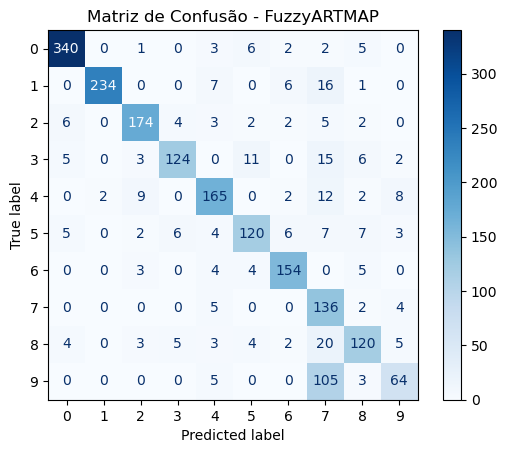

In [9]:
report = classification_report(y_test, fuzzy_artmap_predictions)
matrix = confusion_matrix(y_test, fuzzy_artmap_predictions)

print("\nClassification report:")
print(report)

cm = confusion_matrix(y_test, fuzzy_artmap_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - FuzzyARTMAP")
plt.show()

Confundiu muito 7 e 9

In [10]:
acc_matrix = generate_acc_matrix_fuzzyARTMAP(num_tasks, X_train_sorted, y_train_sorted, 
                                            X_test_sorted, y_test_sorted, 1)

acc_matrix

#print(f"Forward transfer {forward_transfer(num_tasks, acc_matrix)}")
#print(f"Backward transfer {backward_transfer(num_tasks, acc_matrix)}")
#print(f"Average Accuracy {average_accuracy(num_tasks, acc_matrix)}")



RuntimeError: Boolean value of Tensor with more than one value is ambiguous